# Create Spark session

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, rand, col
from pyspark.sql.types import StringType, IntegerType
import random
import pandas as pd
import pyspark
from datetime import datetime
from pyspark import SparkConf, SparkContext

# SparkConfを作成し、メモリ設定を行う
conf = SparkConf() \
    .setAppName("MyApp") \
    .set("spark.driver.memory", "8g") \
    .set("spark.executor.memory", "8g")

# SparkContextを作成
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

24/07/14 03:45:37 WARN Utils: Your hostname, thamaMBP.local resolves to a loopback address: 127.0.0.1; using 172.20.10.2 instead (on interface en0)
24/07/14 03:45:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/14 03:45:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Generate random data

In [8]:
# ランダムデータ生成

colors = ["red", "blue", "yellow"]
sizes = ["l", "m", "s"]

# ランダム選択のための関数
def random_color():
    return random.choice(colors)

def random_size():
    return random.choice(sizes)

def random_value():
    return random.randint(0, 100)

# UDF（ユーザー定義関数）の登録
random_color_udf = udf(random_color, StringType())
random_size_udf = udf(random_size, StringType())
random_value_udf = udf(random_value, IntegerType())

# 空のDataFrameを作成
df = spark.range(100).withColumn("id", col("id"))

# 各カラムをランダム値で埋める
df = df.withColumn("color", random_color_udf())
df = df.withColumn("size", random_size_udf())
df = df.withColumn("value", random_value_udf())

# "id"カラムを削除して最終DataFrameにする
df = df.drop("id")

# 結果を表示
df.show(10)

psdf = df.pandas_api()

+------+----+-----+
| color|size|value|
+------+----+-----+
|   red|   l|   29|
|   red|   s|   22|
|  blue|   l|   94|
|  blue|   l|   78|
|  blue|   l|   87|
|  blue|   m|    8|
|yellow|   l|   44|
|  blue|   l|   33|
|yellow|   m|   37|
|yellow|   s|    3|
+------+----+-----+
only showing top 10 rows



# Data

In [15]:
type(psdf)

pyspark.pandas.frame.DataFrame

In [20]:
psdf.head(5)

,color,size,value
0,yellow,l,68
1,yellow,s,8
2,blue,s,41
3,red,m,78
4,yellow,l,33


# Method 1

これが一番速そう

一度に全部の quantile 計算できないけど accuracy が使える方法（pyspark groupby）

In [14]:
start = datetime.now()

quantiles_dfs = []
for column in ["color", "size"]:
    for quantile in [0.0, 0.25, 0.5, 0.75, 1.0]:
        quantiles = psdf.groupby(column).quantile(quantile, accuracy=100)
        quantiles["quantile"] = quantile
        quantiles["column"] = column
        quantiles_dfs.append(quantiles.reset_index().rename(columns={column: "category"}))

quantiles_df = pyspark.pandas.concat(quantiles_dfs)
quantiles_df = quantiles_df[["column", "category", "quantile", "value"]].sort_values(by=["column", "category", "quantile"]).reset_index(drop=True)

end = datetime.now()
print(end - start)

quantiles_df

0:00:01.018225


,column,category,quantile,value
0,color,blue,0.00,11.0
1,color,blue,0.25,20.0
2,color,blue,0.50,35.0
3,color,blue,0.75,63.0
4,color,blue,1.00,100.0
5,color,red,0.00,3.0
6,color,red,0.25,34.0
7,color,red,0.50,52.0
8,color,red,0.75,75.0
9,color,red,1.00,99.0


# Method 2

一度に複数の quantile を accuracy を指定して計算する方法（pandas の group by を使う）

In [10]:
start = datetime.now()

quantiles_dfs = []
for column in ["color", "size"]:
    for category in psdf[column].unique().values:
        quantiles_df = psdf.loc[psdf[column] == category].quantile([0.0, 0.25, 0.5, 0.75, 1.0], accuracy=100)
        quantiles_df["column"] = column
        quantiles_df['category'] = category
        quantiles_dfs.append(quantiles_df.reset_index().rename(columns={"index": "quantile"}))

quantiles_df = pyspark.pandas.concat(quantiles_dfs)
quantiles_df = quantiles_df[["column", "category", "quantile", "value"]].sort_values(by=["column", "category", "quantile"]).reset_index(drop=True)

end = datetime.now()
print(end - start)

quantiles_df

/Users/thama/ghq/github.com/mathmathpp2/synapselightgbm_trial/synapse-test/.venv/lib/python3.11/site-packages/pyspark/pandas/generic.py:647: UserWarning: We recommend using `Series.to_numpy()` instead.
  warnings.warn("We recommend using `{}.to_numpy()` instead.".format(type(self).__name__))
/Users/thama/ghq/github.com/mathmathpp2/synapselightgbm_trial/synapse-test/.venv/lib/python3.11/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/Users/thama/ghq/github.com/mathmathpp2/synapselightgbm_trial/synapse-test/.venv/lib/python3.11/site-packages/pyspark/pandas/generic.py:647: UserWarning: We recommend using `Series.to_numpy()` instead.
  warnings.warn("We recommend using `{}.to_numpy()` instead.".format(type(self).__name__))
/Users/thama/ghq/github.com/mathmathpp2/synapselightgbm_t

0:00:02.348566


,column,category,quantile,value
0,color,blue,0.00,0.0
1,color,blue,0.25,40.0
2,color,blue,0.50,63.0
3,color,blue,0.75,74.0
4,color,blue,1.00,90.0
5,color,red,0.00,0.0
6,color,red,0.25,19.0
7,color,red,0.50,46.0
8,color,red,0.75,75.0
9,color,red,1.00,100.0


# Method 3

 一度に複数の quantile を計算する方法（pandas の group by を使う） 
 
 100件くらいなら動くけど10万件とかは謎エラーで落ちる

In [11]:
start = datetime.now()

# Calculate quantiles for each category
def calculate_quantiles(group):
    names = [0.0, 0.25, 0.5, 0.75, 1.0]
    quantiles = group.quantile([0.0, 0.25, 0.5, 0.75, 1.0])
    return pd.Series(names, quantiles)

quantiles_dfs = []
for column in ["color", "size"]:
    quantiles_df = psdf.groupby(column)["value"].apply(calculate_quantiles).reset_index().rename(columns={
        column: "category",
        "level_1": "value",
        "value": "quantile"
    })
    quantiles_df["column"] = column
    quantiles_dfs.append(quantiles_df)

quantiles_df = pyspark.pandas.concat(quantiles_dfs)
quantiles_df = quantiles_df[["column", "category", "quantile", "value"]].sort_values(by=["column", "category", "quantile"]).reset_index(drop=True)

end = datetime.now()
print(end - start)

quantiles_df

/Users/thama/ghq/github.com/mathmathpp2/synapselightgbm_trial/synapse-test/.venv/lib/python3.11/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If the type hints is not specified for `groupby.apply`, it is expensive to infer the data type internally.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/Users/thama/ghq/github.com/mathmathpp2/synapselightgbm_trial/synapse-test/.venv/lib/python3.11/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If the type hints is not specified for `groupby.apply`, it is expensive to infer the data type internally.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


0:00:01.042366


,column,category,quantile,value
0,color,blue,0.00,0.00
1,color,blue,0.25,34.50
2,color,blue,0.50,46.00
3,color,blue,0.75,70.50
4,color,blue,1.00,99.00
5,color,red,0.00,1.00
6,color,red,0.25,15.25
7,color,red,0.50,53.00
8,color,red,0.75,70.50
9,color,red,1.00,97.00


# Boxplot

In [12]:
quantiles_pdf = quantiles_df.to_pandas()

/Users/thama/ghq/github.com/mathmathpp2/synapselightgbm_trial/synapse-test/.venv/lib/python3.11/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Text(0, 0.5, 'cm')

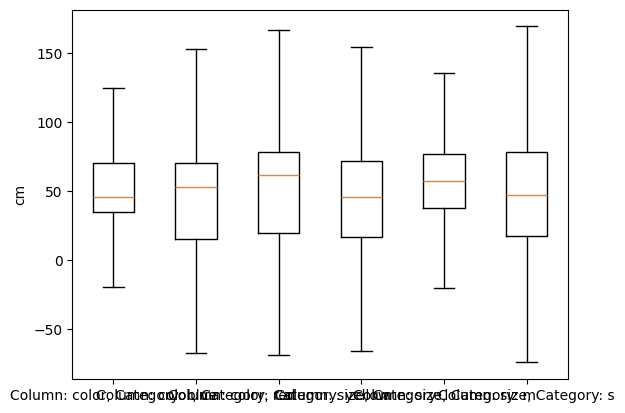

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
boxes = []

for column, category in quantiles_pdf[['column', 'category']].drop_duplicates().to_numpy():
    quantiles = quantiles_pdf.loc[(quantiles_pdf["column"] == column) & (quantiles_pdf["category"] == category)].set_index("quantile")
    q1 = quantiles.loc[0.25, 'value']
    med = quantiles.loc[0.5, 'value']
    q3 = quantiles.loc[0.75, 'value']
    iqr = q3 - q1
    whislo = q1 - 1.5 * iqr
    whishi = q3 + 1.5 * iqr
    
    box = {
        'label' : f"Column: {column}, Category: {category}",
        'whislo': whislo,
        'q1'    : q1,
        'med'   : med,
        'q3'    : q3,
        'whishi': whishi,
        'fliers': []        # Outliers
    }
    boxes.append(box)

ax.bxp(boxes, showfliers=False)
ax.set_ylabel("cm")
# plt.savefig("boxplot.png")
# plt.close()